In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl

import missingno as msno

import matplotlib.pyplot as plt 
%matplotlib inline 
plt.rcParams['font.family'] = 'Malgun Gothic'

import seaborn as sns 

In [2]:
train = pd.read_csv('./train.csv', index_col = 'id')
test = pd.read_csv('./test.csv', index_col = 'id')
submission = pd.read_csv('./sample_submission.csv', index_col = 'id')

# 피처 엔지니어링

## 데이터 합치기

In [3]:
all_data=pd.concat([train,test])
all_data=all_data.drop('target',axis=1)
all_data_features=all_data.columns
all_data_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

## 명목형 피처 원-핫 인코딩

In [4]:
from sklearn.preprocessing import OneHotEncoder

In [5]:
cat_features=[feature for feature in all_data_features if 'cat' in feature]
onehot=OneHotEncoder()
encoded_cat=onehot.fit_transform(all_data[cat_features])
encoded_cat

<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

## 필요 없는 피처 제거

In [6]:
drop_features=['ps_ind_14','ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin','ps_car_14']

원- 핫 인코딩에서 사용한 피처와 제거한 피처를 제외한 피처들

In [7]:
remaining_features=[feature for feature in all_data_features
                   if('cat' not in feature and 
                     'calc' not in feature and
                     feature not in drop_features)]

In [8]:
from scipy import sparse
all_data_sprs=sparse.hstack([sparse.csr_matrix(all_data[remaining_features]),
                            encoded_cat],
                           format='csr')

hstack은 수평 방향으로 합침  
csr형식으로 해야 메모리를 적게 쓰고 연산도 빠름

## 데이 나누기

In [9]:
num_train=len(train)
X=all_data_sprs[:num_train]
X_test=all_data_sprs[num_train:]
y=train['target'].values

# 평가지표 함수 작성

## 지니계수

**지니계수란?**  
원래 경제학에서 쓰는 용어  
소득 불평등 정도를 나타내는 지표  
작을수록 평등하고, 클수록 불평등    
모든 경제인구를 소득 순서대로 나열한 후에 가로축은 인구 누적 비율, 세로축은 소득 누적 점유율로 설정  
인구 누적 비율과 소득 누적 점유율을 연결한 선인 로렌츠 곡선을 이용해 계산  

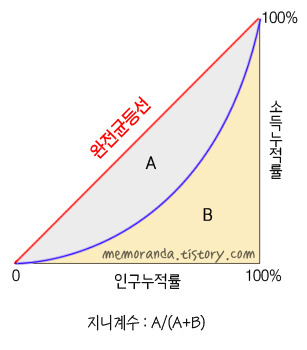

A가 좁을수록 평등

머신러닝에서는 모델의 예측 성능을 측정하는데 사용  
예측값을 크기순으로 정렬해서 로렌츠 곡선을 구함

정규화 지니계수=$\frac{예측값에 대한 지니계수}{예측이 완벽할 때의 지니계수}$  
예측값에 대한 지니계수: 예측값과 실제값으로 구한 지니계수  
예측이 완벽할 때의 지니계수: 실제값과 실제값으로 구한 지니계수

In [10]:
def eval_gini(y_true, y_pred) : 
    # 실제값과 예측값의 크기가 서로 같은지 확인(다르면 에러 발생)
    assert y_true.shape == y_pred.shape
    
    # 데이터 개수
    n_samples = y_true.shape[0]
    # 대각선 값 
    L_mid = np.linspace(1/n_samples, 1, n_samples)
    
    # 1. 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()]
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    G_pred = np.sum(L_mid - L_pred)
    
    # 2. 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()]
    L_true = np.cumsum(true_order) / np.sum(true_order)
    G_true = np.sum(L_mid - L_true)
    
    # 정규화된 지니계수
    return G_pred / G_true

## 피처 엔지니어링

모델 훈련 시 검증 파라미터에 전달하기 위한 함수

In [11]:
# XGBoost용 gini() 함수
def gini(preds, dtrain) : 
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds)

# XGBoost

## 하이퍼파라미터 최적화

In [12]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = \
train_test_split(X, y, test_size = 0.2, random_state = 0)

# 베이지안 최적화용 데이터셋 
bayes_dtrain = xgb.DMatrix(X_train, y_train)
bayes_dvalid = xgb.DMatrix(X_valid, y_valid)

범위 설정

In [13]:
param_bounds = {'max_depth' : (4, 8), 
                'subsample' : (0.6, 0.9),
                'colsample_bytree' : (0.7, 1.0),
                'min_child_weight' : (5, 7),
                'gamma' : (8, 11),
                'reg_alpha' : (7, 9), 
                'reg_lambda' : (1.1, 1.5),
                'scale_pos_weight':(1.4,1.6)}

fixed_params = {'objective' : 'binary:logistic' ,
                'learning_rate' : 0.02,
                'random_state' : 1991}

베이지안 최적화용 평가지표 계산 함수 작성

In [15]:
def eval_function(max_depth, subsample, colsample_bytree, min_child_weight,
                  gamma, reg_alpha, reg_lambda,scale_pos_weight) : 
    
    # 베이지안 최적화를 수행할 하이퍼 파라미터 
    params = {'max_depth' : int(round(max_depth)), 
                'subsample' : subsample,
                'colsample_bytree' : colsample_bytree,
                'min_child_weight' : min_child_weight,
                'gamma' : gamma,
                'reg_alpha' : reg_alpha, 
                'reg_lambda' : reg_lambda,
                'scale_pos_weight' : scale_pos_weight}
    
    # 고정된 하이퍼 파라미터
    params.update(fixed_params)
    
    print('하이퍼파라미터 : ', params)
    
    # XGBoost 훈련 
    xgb_model = xgb.train(params = params,
                          dtrain= bayes_dtrain,
                          num_boost_round = 2000, 
                          evals=[(bayes_dvalid,'bayes_dvalid')],
                          maximize=True,
                          feval=gini,
                          early_stopping_rounds = 200,
                          verbose_eval = False)
    best_iter=xgb_model.best_iteration
    
    # 검증 데이터로 예측 수행 
    preds = xgb_model.predict(bayes_dvalid,iteration_range=(0,best_iter))
    
    # 지니계수
    gini_score = eval_gini(y_valid, preds)
    print(f'지니계수 : {gini_score}\n')
    
    return gini_score

## 최적화 수행

In [16]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(f = eval_function, 
                                 pbounds = param_bounds,
                                 random_state = 0)

In [17]:
optimizer.maximize(init_points = 3, n_iter = 6)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
하이퍼파라미터 :  {'max_depth': 6, 'subsample': 0.867531900234624, 'colsample_bytree': 0.8646440511781974, 'min_child_weight': 6.0897663659937935, 'gamma': 10.14556809911726, 'reg_alpha': 7.84730959867781, 'reg_lambda': 1.3583576452266626, 'scale_pos_weight': 1.4875174422525386, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py:35: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.2836559647242793

|  1        |  0.2837   |  0.8646   |  10.15    |  6.411    |  6.09     |  7.847    |  1.358    |  1.488    |  0.8675   |
하이퍼파라미터 :  {'max_depth': 7, 'subsample': 0.6261387899104622, 'colsample_bytree': 0.9890988281503088, 'min_child_weight': 6.0577898395058085, 'gamma': 9.150324556477333, 'reg_alpha': 8.136089122187865, 'reg_lambda': 1.4702386553170643, 'scale_pos_weight': 1.4142072116395774, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}
지니계수 : 0.285323894164524

|  2        |  0.2853   |  0.9891   |  9.15     |  7.167    |  6.058    |  8.136    |  1.47     |  1.414    |  0.6261   |
하이퍼파라미터 :  {'max_depth': 7, 'subsample': 0.8341587528859367, 'colsample_bytree': 0.7060655192320977, 'min_child_weight': 6.7400242964936385, 'gamma': 10.497859536643814, 'reg_alpha': 8.957236684465528, 'reg_lambda': 1.4196634256866894, 'scale_pos_weight': 1.4922958724505864, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py:35: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.2852690104802081

|  4        |  0.2853   |  0.8843   |  10.45    |  6.838    |  6.494    |  8.552    |  1.381    |  1.423    |  0.7002   |
하이퍼파라미터 :  {'max_depth': 7, 'subsample': 0.8535233675350644, 'colsample_bytree': 0.92975858050776, 'min_child_weight': 6.249564429359247, 'gamma': 9.95563546750357, 'reg_alpha': 8.411512219837842, 'reg_lambda': 1.424460008293778, 'scale_pos_weight': 1.5416807226581535, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py:35: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.2854698436010303

|  5        |  0.2855   |  0.9298   |  9.956    |  6.809    |  6.25     |  8.412    |  1.424    |  1.542    |  0.8535   |
하이퍼파라미터 :  {'max_depth': 7, 'subsample': 0.6462619019069298, 'colsample_bytree': 0.80929192865947, 'min_child_weight': 6.079999276892042, 'gamma': 9.553916776586505, 'reg_alpha': 8.860396362258099, 'reg_lambda': 1.4050740023119348, 'scale_pos_weight': 1.4668544695338273, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py:35: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.2856142564722939

|  6        |  0.2856   |  0.8093   |  9.554    |  6.532    |  6.08     |  8.86     |  1.405    |  1.467    |  0.6463   |
하이퍼파라미터 :  {'max_depth': 7, 'subsample': 0.6931141936797243, 'colsample_bytree': 0.8817801730078565, 'min_child_weight': 6.992334203641873, 'gamma': 9.013424730095146, 'reg_alpha': 7.640858389939128, 'reg_lambda': 1.3562805915715632, 'scale_pos_weight': 1.449446257931491, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py:35: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.2851756681853027

|  7        |  0.2852   |  0.8818   |  9.013    |  6.927    |  6.992    |  7.641    |  1.356    |  1.449    |  0.6931   |
하이퍼파라미터 :  {'max_depth': 5, 'subsample': 0.6261564417044092, 'colsample_bytree': 0.8763145220620449, 'min_child_weight': 5.135323353557588, 'gamma': 8.39495450163982, 'reg_alpha': 8.950443047087845, 'reg_lambda': 1.4235649099168255, 'scale_pos_weight': 1.5217625173811569, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py:35: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.2847997272806962

|  8        |  0.2848   |  0.8763   |  8.395    |  4.561    |  5.135    |  8.95     |  1.424    |  1.522    |  0.6262   |
하이퍼파라미터 :  {'max_depth': 6, 'subsample': 0.857971740304964, 'colsample_bytree': 0.9583821245229369, 'min_child_weight': 6.158305055403563, 'gamma': 9.305332775334449, 'reg_alpha': 8.200928434091152, 'reg_lambda': 1.2571039588093065, 'scale_pos_weight': 1.4700266933495618, 'objective': 'binary:logistic', 'learning_rate': 0.02, 'random_state': 1991}


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py:35: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


지니계수 : 0.28477701037665965

|  9        |  0.2848   |  0.9584   |  9.305    |  5.594    |  6.158    |  8.201    |  1.257    |  1.47     |  0.858    |


## 결과 확인

In [18]:
max_params = optimizer.max['params']
max_params

{'colsample_bytree': 0.80929192865947,
 'gamma': 9.553916776586505,
 'max_depth': 6.531941709363455,
 'min_child_weight': 6.079999276892042,
 'reg_alpha': 8.860396362258099,
 'reg_lambda': 1.4050740023119348,
 'scale_pos_weight': 1.4668544695338273,
 'subsample': 0.6462619019069298}

In [19]:
max_params['max_depth']=int(round(max_params['max_depth']))
max_params.update(fixed_params)
max_params

{'colsample_bytree': 0.80929192865947,
 'gamma': 9.553916776586505,
 'max_depth': 7,
 'min_child_weight': 6.079999276892042,
 'reg_alpha': 8.860396362258099,
 'reg_lambda': 1.4050740023119348,
 'scale_pos_weight': 1.4668544695338273,
 'subsample': 0.6462619019069298,
 'objective': 'binary:logistic',
 'learning_rate': 0.02,
 'random_state': 1991}

In [20]:
from sklearn.model_selection import StratifiedKFold

# 층화 K-Fold 교차 검증기 생성
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1991)

# OOF -> 검증 데이터
oof_val_preds = np.zeros(X.shape[0])

# OOF -> 테스트 데이터
oof_test_preds = np.zeros(X_test.shape[0])

# OOF 훈련, 예측 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)) :
    # 각 폴드 구분
    print('#'*40, f'Fold {idx+1} / Fold {folds.n_splits}' ,'#'*40)
    
    # Split data 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # XGBoost dataset 
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    dtest = xgb.DMatrix(X_test)
    
    # XGBoost training 
    xgb_model = xgb.train(params = max_params,
                          dtrain= dtrain,
                          num_boost_round = 2000, 
                          evals=[(bayes_dvalid,'bayes_dvalid')],
                          maximize=True,
                          feval=gini,
                          early_stopping_rounds = 200,
                          verbose_eval = 100)
    #가장 좋은 부스팅 횟수 저장
    best_iter=xgb_model.best_iteration
   #테스트 데이터를 활용해 OOF 예측
    oof_test_preds += xgb_model.predict(dtest,iteration_range=(0,best_iter))/folds.n_splits
    
     #모델 성능 평가를 위한 검증 데이터 타깃값 예측
    oof_val_preds[valid_idx] += xgb_model.predict(dvalid,iteration_range=(0,best_iter))
    
   #검증 데이터 예측 확률에 대한 정규화 지니계수
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    
    print(f'폴드 {idx+1} 지니계수. : {gini_score}\n')

######################################## Fold 1 / Fold 5 ########################################


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\training.py:35: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	bayes_dvalid-logloss:0.67670	bayes_dvalid-gini:0.14491
[100]	bayes_dvalid-logloss:0.19133	bayes_dvalid-gini:0.24706
[200]	bayes_dvalid-logloss:0.15752	bayes_dvalid-gini:0.28347
[300]	bayes_dvalid-logloss:0.15391	bayes_dvalid-gini:0.30022
[400]	bayes_dvalid-logloss:0.15315	bayes_dvalid-gini:0.30964
[500]	bayes_dvalid-logloss:0.15284	bayes_dvalid-gini:0.31617
[600]	bayes_dvalid-logloss:0.15267	bayes_dvalid-gini:0.32120
[700]	bayes_dvalid-logloss:0.15249	bayes_dvalid-gini:0.32548
[800]	bayes_dvalid-logloss:0.15236	bayes_dvalid-gini:0.32935
[900]	bayes_dvalid-logloss:0.15223	bayes_dvalid-gini:0.33240
[1000]	bayes_dvalid-logloss:0.15210	bayes_dvalid-gini:0.33596
[1100]	bayes_dvalid-logloss:0.15197	bayes_dvalid-gini:0.33913
[1200]	bayes_dvalid-logloss:0.15187	bayes_dvalid-gini:0.34185
[1300]	bayes_dvalid-logloss:0.15176	bayes_dvalid-gini:0.34423
[1400]	bayes_dvalid-logloss:0.15169	bayes_dvalid-gini:0.34649
[1500]	bayes_dvalid-logloss:0.15158	bayes_dvalid-gini:0.34914
[1600]	bayes_dvalid-

In [21]:
print(f'OOF 검증 데이터 지니계수 :' ,eval_gini(y, oof_val_preds))

OOF 검증 데이터 지니계수 : 0.28909097524157995


# 예측 및 결과 제출

In [22]:
submission['target'] = oof_test_preds
submission.to_csv('submission_xgb.csv')

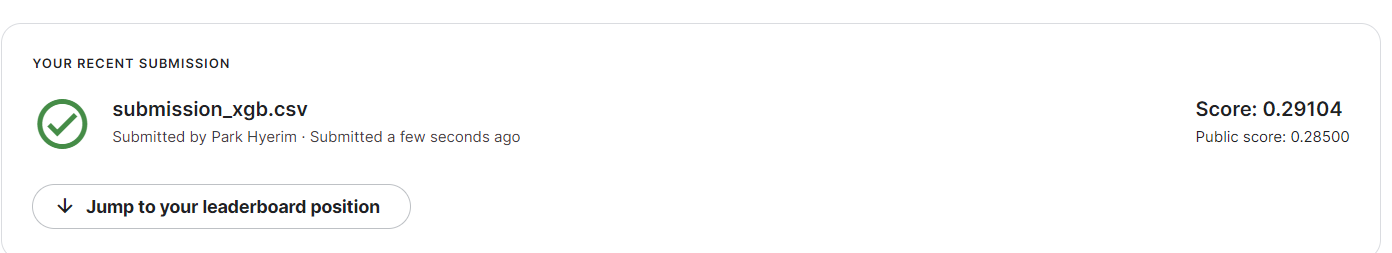

# LightGBM + XGBoost 앙상블

## 앙상블 수행

In [23]:
submission_ensemble =  pd.read_csv('./sample_submission.csv', index_col = 'id')
sub_xgb = pd.read_csv('submission_xgb.csv', index_col = 'id')
sub_lgb = pd.read_csv('submission_lgb.csv', index_col = 'id')

submission_ensemble['target'] = 0.5*sub_xgb['target']+0.5*sub_lgb['target']
submission_ensemble.to_csv('submission_ensemble.csv')

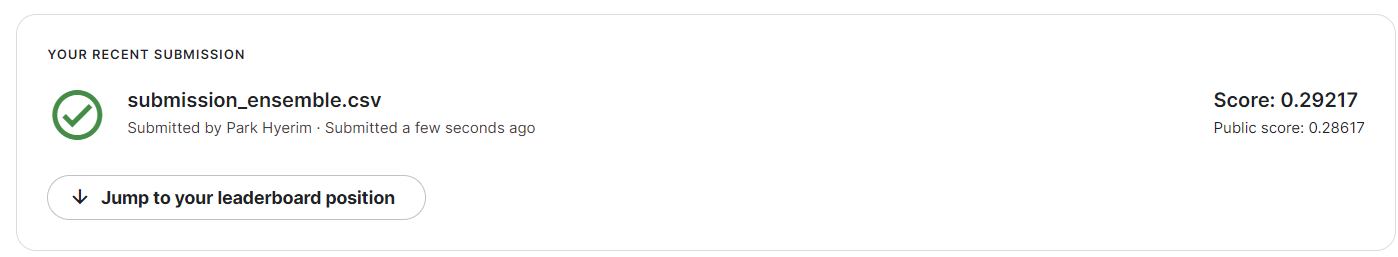